# TimeXer Forecasting with Nixtla's NeuralForecast

## Dataset: AV

This notebook demonstrates how to use the TimeXer forecasting model described in:

*TimeXer: Empowering Transformers for Time Series Forecasting with Exogenous Variables*, [https://arxiv.org/abs/2402.19072](https://arxiv.org/abs/2402.19072)

The implementation we use is provided by Nixtla's NeuralForecast library:

+ for the base model [`TimeXer`](https://nixtlaverse.nixtla.io/neuralforecast/models.timexer.html#timexer)
+ for the automodel [`AutoTimeXer`](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autotimexer)

## Important note:

This notebook uses the following conda environments:

+ Under linux: tfm_cc, described in the tfm_cc.yml file (see environments folder).
+ Under macOS: tfm_cc_nixtla, described in the tfm_cc_nixtla.yml file (see environments folder). 

## Execution Notes:

The run times that appear below correspond to the execution of the notebook in a Linux machine under Ubuntu 22.04 LTS with Intel Core i7-10870H CPU (2.20GHz), 64GB of RAM, NVIDIA GeForce RTX 3060 Laptop GPU with 6Gb VRAM.

## Load basic libraries

**Warning:** Model specific libraries will be loaded below.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import logging



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


## Load dataset

In [4]:
file_path = "../../data/filtered_df.csv"
df = pd.read_csv(file_path, delimiter=';')
df.head()

,time,Active_Power,Wind_speed_tower,Preassure,Generator_Speed,F1_v(90).Mean,F1_v(80).Mean,F1_v(70).Mean,F1_v(60).Mean,F1_v(50).Mean,F1_v(40).Mean,F1_v(30).Mean
0,01/09/2022 0:00,2505.48220,9.057124,1012.38360,1121.2102,9.023969,3.97405,9.076108,3.82628,8.992466,3.39136,8.827003
1,01/09/2022 1:00,1762.24210,8.078237,1012.41210,1073.9020,8.110137,3.97405,8.151952,3.82628,8.076786,3.39136,8.005285
2,01/09/2022 2:00,1460.83560,7.712017,1012.29083,1021.2429,7.527431,3.97405,7.615797,3.82628,7.517593,3.39136,7.461551
3,01/09/2022 3:00,926.81006,6.672135,1012.15690,894.0004,6.566134,3.97405,6.637816,3.82628,6.571112,3.39136,6.550666
4,01/09/2022 4:00,671.34590,6.100095,1012.09424,821.4349,5.988185,3.97405,6.049537,3.82628,5.986922,3.39136,5.982606


### Set datetime format and index

In [5]:
df['time'] = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')
df.set_index('time', inplace=True)
df.head()

,Active_Power,Wind_speed_tower,Preassure,Generator_Speed,F1_v(90).Mean,F1_v(80).Mean,F1_v(70).Mean,F1_v(60).Mean,F1_v(50).Mean,F1_v(40).Mean,F1_v(30).Mean
time,,,,,,,,,,,
2022-09-01 00:00:00,2505.48220,9.057124,1012.38360,1121.2102,9.023969,3.97405,9.076108,3.82628,8.992466,3.39136,8.827003
2022-09-01 01:00:00,1762.24210,8.078237,1012.41210,1073.9020,8.110137,3.97405,8.151952,3.82628,8.076786,3.39136,8.005285
2022-09-01 02:00:00,1460.83560,7.712017,1012.29083,1021.2429,7.527431,3.97405,7.615797,3.82628,7.517593,3.39136,7.461551
2022-09-01 03:00:00,926.81006,6.672135,1012.15690,894.0004,6.566134,3.97405,6.637816,3.82628,6.571112,3.39136,6.550666
2022-09-01 04:00:00,671.34590,6.100095,1012.09424,821.4349,5.988185,3.97405,6.049537,3.82628,5.986922,3.39136,5.982606


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7248 entries, 2022-09-01 00:00:00 to 2023-06-29 23:00:00
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Active_Power      7248 non-null   float64
 1   Wind_speed_tower  7248 non-null   float64
 2   Preassure         7248 non-null   float64
 3   Generator_Speed   7248 non-null   float64
 4   F1_v(90).Mean     7162 non-null   float64
 5   F1_v(80).Mean     7162 non-null   float64
 6   F1_v(70).Mean     7162 non-null   float64
 7   F1_v(60).Mean     7162 non-null   float64
 8   F1_v(50).Mean     7162 non-null   float64
 9   F1_v(40).Mean     7162 non-null   float64
 10  F1_v(30).Mean     7162 non-null   float64
dtypes: float64(11)
memory usage: 679.5 KB


In this example, we only use the following variables:

In [7]:
df = df.iloc[:, :4]

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7248 entries, 2022-09-01 00:00:00 to 2023-06-29 23:00:00
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Active_Power      7248 non-null   float64
 1   Wind_speed_tower  7248 non-null   float64
 2   Preassure         7248 non-null   float64
 3   Generator_Speed   7248 non-null   float64
dtypes: float64(4)
memory usage: 283.1 KB


### Check for missing values, time gaps, and duplicated dates

There are no missing data in this dataset

In [8]:
print(df.isna().sum())

Active_Power        0
Wind_speed_tower    0
Preassure           0
Generator_Speed     0
dtype: int64


In [9]:
duplicate_dates = df.index[df.index.duplicated(keep='first')]
print(f"Number of duplicate timestamps: {len(duplicate_dates)}")
print(duplicate_dates)

Number of duplicate timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)


In [10]:
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_dates = expected_range.difference(df.index)

print(f"Number of missing timestamps: {len(missing_dates)}")
print(missing_dates[:30])  # show first 10 missing ones

Number of missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


### Target and exogenous variables

In [11]:
target = 'Active_Power'

features = [col for col in df.columns if col != target]
features = features[:1]
features


['Wind_speed_tower']

In [12]:
df = df[features + [target]]
df

,Wind_speed_tower,Active_Power
time,,
2022-09-01 00:00:00,9.057124,2505.48220
2022-09-01 01:00:00,8.078237,1762.24210
2022-09-01 02:00:00,7.712017,1460.83560
2022-09-01 03:00:00,6.672135,926.81006
2022-09-01 04:00:00,6.100095,671.34590
...,...,...
2023-06-29 19:00:00,6.510803,843.02400
2023-06-29 20:00:00,6.739559,954.61980
2023-06-29 21:00:00,5.570358,530.78204


## Train / Validation / Test split

We select the following lengths for the train, validation, and test sets:

In [13]:
train_len = 5800 # approx int(np.ceil(df.shape[0] * 0.8))
print(f"Train length: {train_len}")

val_len = (df.shape[0] - train_len) // 2
print(f"Validation length: {val_len}")

test_len = df.shape[0] - train_len - val_len
print(f"Test length: {test_len}")

Train length: 5800
Validation length: 724
Test length: 724


And we split the time series into train, validation, and test sets:

In [14]:
train_df = df.iloc[:train_len]
train_df

,Wind_speed_tower,Active_Power
time,,
2022-09-01 00:00:00,9.057124,2505.482200
2022-09-01 01:00:00,8.078237,1762.242100
2022-09-01 02:00:00,7.712017,1460.835600
2022-09-01 03:00:00,6.672135,926.810060
2022-09-01 04:00:00,6.100095,671.345900
...,...,...
2023-04-30 11:00:00,4.004780,150.152160
2023-04-30 12:00:00,3.007964,0.000000
2023-04-30 13:00:00,1.408475,8.929723


In [15]:
val_df = df.iloc[train_len:(train_len + val_len)]
val_df

,Wind_speed_tower,Active_Power
time,,
2023-04-30 16:00:00,3.812496,178.24010
2023-04-30 17:00:00,3.483967,0.00000
2023-04-30 18:00:00,4.239082,147.56505
2023-04-30 19:00:00,4.626727,274.05078
2023-04-30 20:00:00,5.066225,449.61557
...,...,...
2023-05-30 15:00:00,3.378462,0.00000
2023-05-30 16:00:00,3.660170,158.17046
2023-05-30 17:00:00,3.581221,148.18813


In [16]:
test_df = df.iloc[(train_len + val_len):]
test_df

,Wind_speed_tower,Active_Power
time,,
2023-05-30 20:00:00,3.526134,141.81660
2023-05-30 21:00:00,3.746263,170.12517
2023-05-30 22:00:00,2.346617,0.00000
2023-05-30 23:00:00,2.987464,0.00000
2023-05-31 00:00:00,3.670265,159.70273
...,...,...
2023-06-29 19:00:00,6.510803,843.02400
2023-06-29 20:00:00,6.739559,954.61980
2023-06-29 21:00:00,5.570358,530.78204


## Time series split visualization

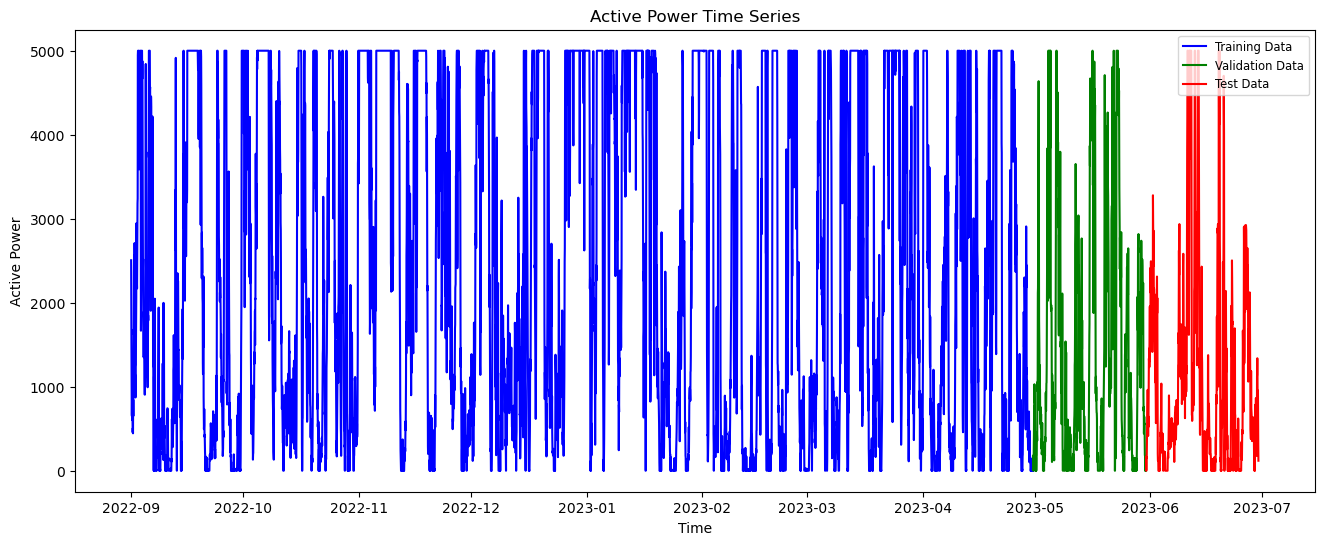

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(train_df["Active_Power"], label="Training Data", color='blue')
plt.plot(val_df["Active_Power"], label="Validation Data", color='green')
plt.plot(test_df["Active_Power"], label="Test Data", color='red')
plt.title("Active Power Time Series")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend(fontsize='small')

We will also create copies of the train, validation, and test sets to use them later in the notebook.

In [18]:
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

## Data scaling

We apply the min-max scaler fitted to the training set to the train, validation, and test sets (to avoid data leakage). 

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

scaler.fit(train_df)
train_df = scaler.transform(train_df)

val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

Let us check the result

In [20]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind_speed_tower,5800.0,0.370283,0.181766,0.0,0.230103,0.341549,0.499679,1.0
Active_Power,5800.0,0.502231,0.396148,0.0,0.112238,0.416912,1.000000,1.0


## Nixtla Dataset Format

Convert to NeuralForecast format (ds, y, unique_id)

In [21]:
train_df_nf = train_df.copy()

train_df_nf = train_df_nf.rename(columns={target: 'y'})

train_df_nf['ds'] = train_df_nf.index

train_df_nf['unique_id'] = 'series_1'


Move ds and unique_id to front

In [22]:
train_df_nf = train_df_nf[['unique_id', 'ds', 'y'] + features]
train_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2022-09-01 00:00:00,series_1,2022-09-01 00:00:00,0.501096,0.372027
2022-09-01 01:00:00,series_1,2022-09-01 01:00:00,0.352448,0.331578
2022-09-01 02:00:00,series_1,2022-09-01 02:00:00,0.292167,0.316446
2022-09-01 03:00:00,series_1,2022-09-01 03:00:00,0.185362,0.273476
2022-09-01 04:00:00,series_1,2022-09-01 04:00:00,0.134269,0.249839
...,...,...,...,...
2023-04-30 11:00:00,series_1,2023-04-30 11:00:00,0.030030,0.163258
2023-04-30 12:00:00,series_1,2023-04-30 12:00:00,0.000000,0.122068
2023-04-30 13:00:00,series_1,2023-04-30 13:00:00,0.001786,0.055975


Same for validation and test sets

In [23]:
val_df_nf = val_df.copy()
val_df_nf = val_df_nf.rename(columns={target: 'y'})
val_df_nf['ds'] = val_df_nf.index

val_df_nf['unique_id'] = 'series_1'

val_df_nf = val_df_nf[['unique_id', 'ds', 'y'] + features]
val_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2023-04-30 16:00:00,series_1,2023-04-30 16:00:00,0.035648,0.155312
2023-04-30 17:00:00,series_1,2023-04-30 17:00:00,0.000000,0.141737
2023-04-30 18:00:00,series_1,2023-04-30 18:00:00,0.029513,0.172939
2023-04-30 19:00:00,series_1,2023-04-30 19:00:00,0.054810,0.188957
2023-04-30 20:00:00,series_1,2023-04-30 20:00:00,0.089923,0.207118
...,...,...,...,...
2023-05-30 15:00:00,series_1,2023-05-30 15:00:00,0.000000,0.137377
2023-05-30 16:00:00,series_1,2023-05-30 16:00:00,0.031634,0.149018
2023-05-30 17:00:00,series_1,2023-05-30 17:00:00,0.029638,0.145756


In [24]:
test_df_nf = test_df.copy()
test_df_nf = test_df_nf.rename(columns={target: 'y'})
test_df_nf['ds'] = test_df_nf.index

test_df_nf['unique_id'] = 'series_1'

test_df_nf = test_df_nf[['unique_id', 'ds', 'y'] + features]
test_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2023-05-30 20:00:00,series_1,2023-05-30 20:00:00,0.028363,0.143479
2023-05-30 21:00:00,series_1,2023-05-30 21:00:00,0.034025,0.152575
2023-05-30 22:00:00,series_1,2023-05-30 22:00:00,0.000000,0.094740
2023-05-30 23:00:00,series_1,2023-05-30 23:00:00,0.000000,0.121221
2023-05-31 00:00:00,series_1,2023-05-31 00:00:00,0.031941,0.149435
...,...,...,...,...
2023-06-29 19:00:00,series_1,2023-06-29 19:00:00,0.168605,0.266810
2023-06-29 20:00:00,series_1,2023-06-29 20:00:00,0.190924,0.276262
2023-06-29 21:00:00,series_1,2023-06-29 21:00:00,0.106156,0.227949


Create a **joint dataset** with train and validation to fit into Nixtla's framework.

In [25]:
train_val_df = pd.concat([train_df_nf, val_df_nf], axis=0)
train_val_df.reset_index(drop=True, inplace=True)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         6524 non-null   object        
 1   ds                6524 non-null   datetime64[ns]
 2   y                 6524 non-null   float64       
 3   Wind_speed_tower  6524 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 204.0+ KB


And similarly a **full dataset** with train, validation and test sets.

In [26]:
full_df_nf = pd.concat([train_df_nf, val_df_nf, test_df_nf], axis=0)
full_df_nf.reset_index(drop=True, inplace=True)
full_df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         7248 non-null   object        
 1   ds                7248 non-null   datetime64[ns]
 2   y                 7248 non-null   float64       
 3   Wind_speed_tower  7248 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 226.6+ KB


## Set the forecast horizon and input length

In [27]:
horizon = 3
input_size = 6

# AutoTimeXer

In [30]:
import logging

import optuna

import torch

from neuralforecast import NeuralForecast

from neuralforecast.losses.pytorch import MAE


Check if CUDA is available (Linux machines)

In [31]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [33]:
if torch.cuda.is_available():
    print(torch.cuda.device_count(), torch.cuda.current_device(),torch.cuda.get_device_name(0))

1 0 NVIDIA GeForce RTX 3060 Laptop GPU


Define the hyperparameters for the model. The first group is fixed and shouldn't changed from model to model. The second group is the hyperparameters that are tuned by the AutoTimeXer algorithm using Optuna as backend and may be specific to the model's architecture. The documentations for the hyperparameters can be seen at the [TimeXer](https://nixtlaverse.nixtla.io/neuralforecast/models.TimeXer.html#TimeXer) and [AutoTimeXer](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autoTimeXer) documentation.

**Note:** in the case of TimeXer we need an auxiliary function to define the valid patch sizes for the model. This is because the model requires the input length to be divisible by the patch size, and the patch size is a hyperparameter that is tuned by AutoTimeXer.


In [34]:
def valid_patch_sizes(input_size: int, min_patch: int = 3) -> list:
    """Return all integer divisors of input_size greater than min_patch."""
    return [i for i in range(min_patch + 1, input_size + 1) if input_size % i == 0]

patch_sizes = valid_patch_sizes(input_size)
print(f"Valid patch sizes for input size {input_size}: {patch_sizes}")

Valid patch sizes for input size 6: [6]


In [35]:
def config_TimeXer(trial: optuna.Trial) -> dict:
    return {
        # Fixed

        "input_size": input_size,
        "futr_exog_list": ['Wind_speed_tower'],
        # "scaler_type":'standard',
        "max_steps": 300,
        "val_check_steps": 50,
        "random_seed": 42,
        
        ##### Optuna, model specific
        "n_series": 1,  # Number of time series 
        "patch_len": trial.suggest_categorical("patch_len", patch_sizes),
        "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256, 512]),
        "n_heads": trial.suggest_categorical("n_heads", [8, 16, 32]),
        "e_layers": trial.suggest_int("e_layers", 1, 4),
        "d_ff": trial.suggest_categorical("d_ff", [64, 128, 256, 512]),
        "factor": trial.suggest_float("factor", 0.5, 1.5),
        "dropout": trial.suggest_float("dropout", 0.0, 0.3),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)        
    }


Next we define the AutoTimeXer object. This includes the num_samples parameter, which is the number of samples to be used for the Optuna search. The loss is also an essential parameter of this object.

In [36]:
from neuralforecast.auto import AutoTimeXer

model = AutoTimeXer(
    h=horizon,
    n_series = 1,
    config=config_TimeXer,
    backend='optuna',    
    search_alg=optuna.samplers.TPESampler(),
    gpus=torch.cuda.device_count(),
    ################
    num_samples=100,
    loss=MAE())
    



With this we are ready to perform the search. We pass the size of the validation set to be used for Optuna in selecting the hyperparameters.

In [37]:
%%capture

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)

start_time = time.time()

nf = NeuralForecast(models=[model], freq='H')
nf.fit(df=train_val_df, val_size=val_df_nf.shape[0])

end_time = time.time()
elapsed_time = end_time - start_time

2025-06-18 09:03:08.091425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750230188.107274   35563 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750230188.111823   35563 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 09:03:08.127541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
print(f"Elapsed time: {elapsed_time / 60:.2f} minutes")

Elapsed time: 14.33 minutes


When the search is finished the final model is in  nf.models[0] and it has a results object that contains all  the fit information, including the Optuna study object. In particular, the best_trial attribute has in turn an attribute which is the dictionary of the best hyperparameters.

In [39]:
type(nf.models[0].results)

optuna.study.study.Study

In [40]:
best_params = nf.models[0].results.best_trial.params
best_params

{'patch_len': 6,
 'hidden_size': 128,
 'n_heads': 16,
 'e_layers': 3,
 'd_ff': 128,
 'factor': 0.9364966480263726,
 'dropout': 0.10389682969033395,
 'learning_rate': 0.00010569755514738771}

# TimeXer modeling

Using the best hyperparameters we can now fit a final model. This is done by passing the best hyperparameters to the model and then fitting it to the training + validation set. 


In [43]:
from neuralforecast.models.timexer import TimeXer

model = TimeXer(
    h=horizon,
    n_series=1,
    input_size=input_size,
    loss=MAE(),
    max_steps=600,
    random_seed=42,
    **best_params
)


**NOTE:** We need to set the `EXOGENOUS_HIST` attribute to `True` because the current Nixtla implementation of TimeXer does not expose this attibute in the class argument list.


In [44]:
model.EXOGENOUS_HIST = True
model.hist_exog_list= ['Wind_speed_tower']

In [45]:
%%capture

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)

start_time = time.time()

nf = NeuralForecast(models=[model], freq='H')

nf.fit(df=train_val_df)

end_time = time.time()
elapsed_time = end_time - start_time

In [46]:
print(f"Elapsed time: {elapsed_time / 60:.2f} minutes")

Elapsed time: 0.24 minutes


# Model Performance Evaluation

We create the rolling_df dataframe that contains the series data up to the time instant in which we make a prediction that corresponds to the first time instant in the test set. That prediction corresponds to the maximum value of the prediction horizon. 

In [47]:
rolling_df = full_df_nf.iloc[:(train_len + val_len + 1 - horizon)]
rolling_df.tail(2)

,unique_id,ds,y,Wind_speed_tower
6520,series_1,2023-05-30 16:00:00,0.031634,0.149018
6521,series_1,2023-05-30 17:00:00,0.029638,0.145756


Now to start the evaluation we fit the model to this dataset and get the predictions. We will not use all of them, only the last.

In [48]:
%%capture

nf.fit(df=rolling_df)

In [49]:
%%capture

rolling_preds = nf.predict()
rolling_preds

Note the last of these predictions corresponds to the first time instant in the test set. 

Now we create a dictionary (of dataframes) to store the predictions for each value k from 1 to the max of the prediction horizon. The weird (k-1):k bit below is to prevent pandas from collapsing the row into a series!

In [50]:
preds_df = {}
for k in range(1, horizon + 1):
    preds_df_name = str(k) + "h"  # String variable for the new name
    preds_df[preds_df_name] = rolling_preds.copy().iloc[(k-1):k, :]



Initially we store the predictions we obtained above in the dictionary (only the last one of these will actually be useful for comparison with the test set, but the others serve the purpose of dictionary initialisation).

In [51]:
preds_df['1h']

,unique_id,ds,TimeXer
0,series_1,2023-05-30 18:00:00,0.029675


In [52]:
preds_df['2h']

,unique_id,ds,TimeXer
1,series_1,2023-05-30 19:00:00,0.023061


In [53]:
preds_df['3h']

,unique_id,ds,TimeXer
2,series_1,2023-05-30 20:00:00,0.024797


The main tool for evaluation is the for loop below. In each iteration we add one time instant to the rolling_df dataframe and then we fit the model to this dataframe. We then obtain the predictions for this augmented dataset and our forecasting horizon. And we store each  of them in the corresponing dataframe inside the dictionary. 

In [54]:
start_time = time.time()

In [55]:
%%capture

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)

# for k in range(2, 50): ## Testing
for k in range(2, len(test_df_nf) + horizon):
    # rolling_df = pd.concat([train_df_nf, val_df_nf, test_df_nf.iloc[:k]])
    rolling_df = full_df_nf.iloc[:(train_len + val_len + k - horizon)]
    # print(rolling_df.tail(1))
    # print(rolling_df.shape)
    nf.fit(df=rolling_df)
    rolling_preds = nf.predict()
    # print(rolling_preds)
    for h in range(1, horizon + 1):
        preds_df[f'{h}h'] = pd.concat([preds_df[f'{h}h'], rolling_preds.iloc[(h - 1):h,:]], axis=0)

    print(f"k =  {k}")
    print("#" * 20)

end_time = time.time()       

In [56]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time / 60:.2f} minutes")

Elapsed time: 181.78 minutes


For ease of comparison and plotting we reindex the predictions dataframes in the dictionary to use ds as index.

In [57]:
for h in range(1, horizon + 1):
    preds_df[f'{h}h'].set_index('ds', inplace=True)

After doing that they look like this:

In [58]:
preds_df['1h'] 

,unique_id,TimeXer
ds,,
2023-05-30 18:00:00,series_1,0.029675
2023-05-30 19:00:00,series_1,0.002331
2023-05-30 20:00:00,series_1,-0.001566
2023-05-30 21:00:00,series_1,0.026332
2023-05-30 22:00:00,series_1,0.034742
...,...,...
2023-06-29 19:00:00,series_1,0.073593
2023-06-29 20:00:00,series_1,0.158674
2023-06-29 21:00:00,series_1,0.182369


In [59]:
preds_df['2h'] 

,unique_id,TimeXer
ds,,
2023-05-30 19:00:00,series_1,0.023061
2023-05-30 20:00:00,series_1,-0.000593
2023-05-30 21:00:00,series_1,-0.003369
2023-05-30 22:00:00,series_1,0.020412
2023-05-30 23:00:00,series_1,0.032367
...,...,...
2023-06-29 20:00:00,series_1,0.048417
2023-06-29 21:00:00,series_1,0.158544
2023-06-29 22:00:00,series_1,0.183650


In [60]:
preds_df['3h'] 

,unique_id,TimeXer
ds,,
2023-05-30 20:00:00,series_1,0.024797
2023-05-30 21:00:00,series_1,-0.001107
2023-05-30 22:00:00,series_1,-0.001188
2023-05-30 23:00:00,series_1,0.022707
2023-05-31 00:00:00,series_1,0.033993
...,...,...
2023-06-29 21:00:00,series_1,0.041993
2023-06-29 22:00:00,series_1,0.160224
2023-06-29 23:00:00,series_1,0.180022


Let us plot the predictions against the test set values.

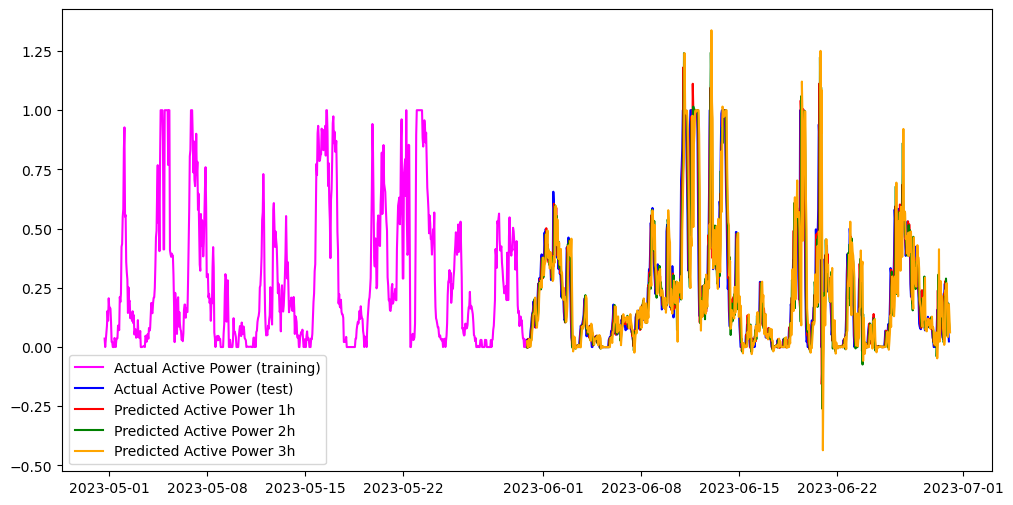

In [61]:
%matplotlib inline

plt.figure(figsize=(12, 6))
# plt.plot(val_df_nf["y"].tail(20), label="Actual Active Power (training)", color='magenta')
# plt.plot(test_df_nf["y"].head(20), label="Actual Active Power (test)", color='blue')
plt.plot(val_df_nf["y"], label="Actual Active Power (training)", color='magenta')
plt.plot(test_df_nf["y"], label="Actual Active Power (test)", color='blue')
plt.plot(preds_df['1h']['TimeXer'][2:], label="Predicted Active Power 1h", color='red')
plt.plot(preds_df['2h']['TimeXer'][1:], label="Predicted Active Power 2h", color='green')
plt.plot(preds_df['3h']['TimeXer'], label="Predicted Active Power 3h", color='orange')

plt.legend()
plt.show();plt.close()


### MAE computation

We will next compute the MAE for each of the predictions in the dictionary. The trickiest part here is to ensure that the predictions are aligned with the test set. 

In [62]:
from sklearn.metrics import mean_absolute_error

In [63]:
test_df_nf.index.min(), test_df_nf.index.max()

(Timestamp('2023-05-30 20:00:00'), Timestamp('2023-06-29 23:00:00'))

In [64]:
test_df_nf['Wind_speed_tower']

time
2023-05-30 20:00:00    0.143479
2023-05-30 21:00:00    0.152575
2023-05-30 22:00:00    0.094740
2023-05-30 23:00:00    0.121221
2023-05-31 00:00:00    0.149435
                         ...   
2023-06-29 19:00:00    0.266810
2023-06-29 20:00:00    0.276262
2023-06-29 21:00:00    0.227949
2023-06-29 22:00:00    0.205115
2023-06-29 23:00:00    0.171232
Name: Wind_speed_tower, Length: 724, dtype: float64

In [65]:
mape1h_df = preds_df['1h'].copy()[2:][['TimeXer']]
mape1h_df


,TimeXer
ds,
2023-05-30 20:00:00,-0.001566
2023-05-30 21:00:00,0.026332
2023-05-30 22:00:00,0.034742
2023-05-30 23:00:00,0.005341
2023-05-31 00:00:00,0.001271
...,...
2023-06-29 19:00:00,0.073593
2023-06-29 20:00:00,0.158674
2023-06-29 21:00:00,0.182369


We need to add the exogenous variables as they were used by the scaler. 

In [66]:
mape1h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mape1h_df

,Wind_speed_tower,TimeXer
ds,,
2023-05-30 20:00:00,0.143479,-0.001566
2023-05-30 21:00:00,0.152575,0.026332
2023-05-30 22:00:00,0.094740,0.034742
2023-05-30 23:00:00,0.121221,0.005341
2023-05-31 00:00:00,0.149435,0.001271
...,...,...
2023-06-29 19:00:00,0.266810,0.073593
2023-06-29 20:00:00,0.276262,0.158674
2023-06-29 21:00:00,0.227949,0.182369


In [67]:
# mape1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mape1h_df)[:,1], test_df_original["Active_Power"])

263.7696244851282

#### Mae for 2h preddictions

In [68]:
mape2h_df = preds_df['2h'].copy()[1:][:-1][['TimeXer']]
mape2h_df


,TimeXer
ds,
2023-05-30 20:00:00,-0.000593
2023-05-30 21:00:00,-0.003369
2023-05-30 22:00:00,0.020412
2023-05-30 23:00:00,0.032367
2023-05-31 00:00:00,0.005037
...,...
2023-06-29 19:00:00,0.238871
2023-06-29 20:00:00,0.048417
2023-06-29 21:00:00,0.158544


In [69]:
mape2h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mape2h_df

,Wind_speed_tower,TimeXer
ds,,
2023-05-30 20:00:00,0.143479,-0.000593
2023-05-30 21:00:00,0.152575,-0.003369
2023-05-30 22:00:00,0.094740,0.020412
2023-05-30 23:00:00,0.121221,0.032367
2023-05-31 00:00:00,0.149435,0.005037
...,...,...
2023-06-29 19:00:00,0.266810,0.238871
2023-06-29 20:00:00,0.276262,0.048417
2023-06-29 21:00:00,0.227949,0.158544


In [70]:
# mape1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mape2h_df)[:,1], test_df_original["Active_Power"])

411.95864763983036

#### Mae for 3h preddictions

In [71]:
mape3h_df = preds_df['3h'].copy()[:-2][['TimeXer']]
mape3h_df


,TimeXer
ds,
2023-05-30 20:00:00,0.024797
2023-05-30 21:00:00,-0.001107
2023-05-30 22:00:00,-0.001188
2023-05-30 23:00:00,0.022707
2023-05-31 00:00:00,0.033993
...,...
2023-06-29 19:00:00,0.269696
2023-06-29 20:00:00,0.200954
2023-06-29 21:00:00,0.041993


In [72]:
mape3h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mape3h_df

,Wind_speed_tower,TimeXer
ds,,
2023-05-30 20:00:00,0.143479,0.024797
2023-05-30 21:00:00,0.152575,-0.001107
2023-05-30 22:00:00,0.094740,-0.001188
2023-05-30 23:00:00,0.121221,0.022707
2023-05-31 00:00:00,0.149435,0.033993
...,...,...
2023-06-29 19:00:00,0.266810,0.269696
2023-06-29 20:00:00,0.276262,0.200954
2023-06-29 21:00:00,0.227949,0.041993


In [73]:
mean_absolute_error(scaler.inverse_transform(mape3h_df)[:,1], test_df_original["Active_Power"])

518.8424311861705